In [6]:
import pandas as pd
df = pd.read_csv('online.csv')

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [9]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [10]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Предобработка данных и разработка признаков 

In [11]:
df['CustomerID'] = df['CustomerID'].fillna(df['CustomerID'].mean())
df['Description'] = df['Description'].fillna('Unknown')

In [14]:
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

In [18]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 530104 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    530104 non-null  object        
 1   StockCode    530104 non-null  object        
 2   Description  530104 non-null  object        
 3   Quantity     530104 non-null  int64         
 4   InvoiceDate  530104 non-null  datetime64[ns]
 5   UnitPrice    530104 non-null  float64       
 6   CustomerID   530104 non-null  float64       
 7   Country      530104 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 36.4+ MB
None
            Quantity                    InvoiceDate      UnitPrice  \
count  530104.000000                         530104  530104.000000   
mean       10.542037  2011-07-04 20:16:05.225087744       3.907625   
min         1.000000            2010-12-01 08:26:00       0.001000   
25%         1.000000        

Создание признаков

In [ ]:
# общая стоимость позиции
df['TotalValue'] = df['Quantity'] * df['UnitPrice']

# 1. Частота (количество транзакций)
frequency = df.groupby('CustomerID')['InvoiceNo'].nunique().rename('Frequency')

# 2. Денежное значение (общие расходы)
monetary_value = df.groupby('CustomerID')['TotalValue'].sum().rename('MonetaryValue')

# 3. Давность (дни с последней покупки)
latest_date = df['InvoiceDate'].max()  # Последняя дата в наборе данных
recency = (latest_date - df.groupby('CustomerID')['InvoiceDate'].max()).dt.days.rename('Recency')

# 4. Общее количество купленных товаров
total_quantity = df.groupby('CustomerID')['Quantity'].sum().rename('TotalQuantity')

# 5. Количество уникальных продуктов
unique_products = df.groupby('CustomerID')['StockCode'].nunique().rename('UniqueProducts')

# 6. Средняя стоимость заказа
average_order_value = (monetary_value / frequency).rename('AverageOrderValue')


customer_features = pd.concat([frequency, monetary_value, recency, total_quantity, unique_products, average_order_value], axis=1)


In [20]:
customer_features

,Frequency,MonetaryValue,Recency,TotalQuantity,UniqueProducts,AverageOrderValue
CustomerID,,,,,,
12346.0,1,77183.60,325,74215,1,77183.600000
12347.0,7,4310.00,1,2458,103,615.714286
12348.0,4,1797.24,74,2341,22,449.310000
12349.0,1,1757.55,18,631,73,1757.550000
12350.0,1,334.40,309,197,17,334.400000
...,...,...,...,...,...,...
18280.0,1,180.60,277,45,10,180.600000
18281.0,1,80.82,180,54,7,80.820000
18282.0,2,178.05,7,103,12,89.025000


Снижение размерности и PCA анализ

In [36]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Шаг 1: Стандартизация данных
scaler = StandardScaler()
standardized_data = scaler.fit_transform(customer_features)

# Шаг 2: Применение PCA
n_components = 2  # Указываем количество главных компонент
pca = PCA(n_components=n_components)
reduced_data = pca.fit_transform(standardized_data)

# Шаг 3: Анализ доли объясненной дисперсии
explained_variance_ratio_sklearn = pca.explained_variance_ratio_
print("Доли объясненной дисперсии для компонент:")
for i, var_ratio in enumerate(explained_variance_ratio_sklearn, 1):
    print(f"PC{i}: {var_ratio:.2%}")

# Преобразуем данные в DataFrame для удобства
reduced_data_df = pd.DataFrame(reduced_data, columns=[f'PC{i+1}' for i in range(n_components)])
print("\nПервые строки преобразованных данных:")
print(reduced_data_df.head())

Доли объясненной дисперсии для компонент:
PC1: 56.31%
PC2: 17.92%

Первые строки преобразованных данных:
        PC1        PC2
0  9.408329  29.887733
1  0.436434  -0.661250
2 -0.112124   0.012732
3  0.052831  -0.106781
4 -0.603579   1.620163


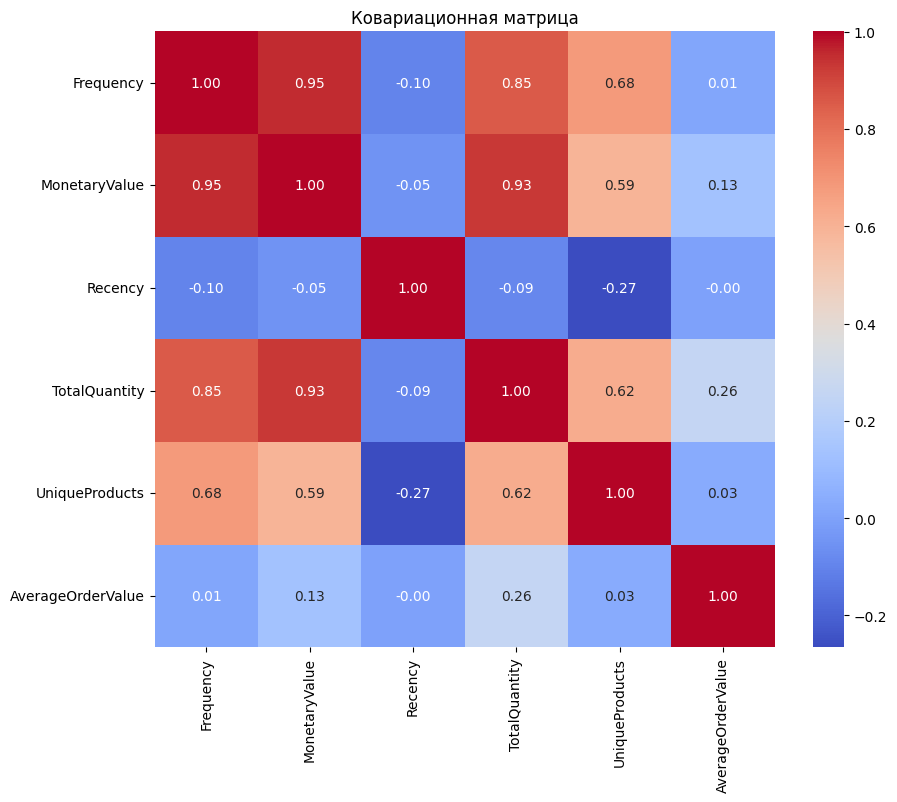

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns


cov_matrix = np.cov(standardized_data.T)

# Создаем тепловую карту
plt.figure(figsize=(10, 8))
sns.heatmap(cov_matrix, annot=True, fmt=".2f", cmap='coolwarm', xticklabels=customer_features.columns, yticklabels=customer_features.columns)
plt.title('Ковариационная матрица')
plt.show()

Вручная версия

In [38]:

import numpy as np

def standardize_data(df):
    mean = np.mean(df, axis=0)
    std = np.std(df, axis=0)
    return (df - mean) / std


standardized_data1 = standardize_data(customer_features)


cov_matrix = np.cov(standardized_data1.T)  


eigvals, eigvecs = np.linalg.eig(cov_matrix)


eigvals_sorted_indices = np.argsort(eigvals)[::-1]  
eigvals_sorted = eigvals[eigvals_sorted_indices]
eigvecs_sorted = eigvecs[:, eigvals_sorted_indices]

n_components = 2
reduced_data = standardized_data1.dot(eigvecs_sorted[:, :n_components])


explained_variance_ratio = eigvals_sorted[:n_components] / np.sum(eigvals_sorted)


for i, var_ratio in enumerate(explained_variance_ratio, 1):
    print(f"PC{i}: {var_ratio:.2%}")


reduced_data_df = pd.DataFrame(reduced_data, columns=[f'PC{i+1}' for i in range(n_components)])


print(reduced_data_df.head())

PC1: 56.31%
PC2: 17.92%
            PC1  PC2
CustomerID          
12346.0     NaN  NaN
12347.0     NaN  NaN
12348.0     NaN  NaN
12349.0     NaN  NaN
12350.0     NaN  NaN


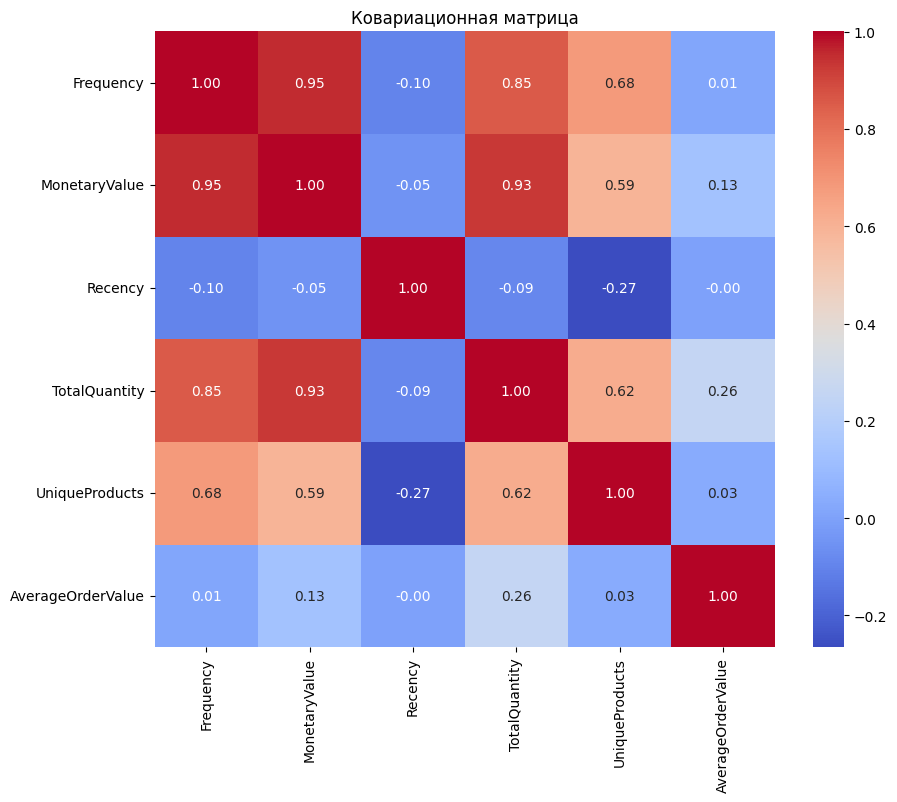

In [39]:
cov_matrix1 = np.cov(standardized_data1.T)

# Создаем тепловую карту
plt.figure(figsize=(10, 8))
sns.heatmap(cov_matrix1, annot=True, fmt=".2f", cmap='coolwarm', xticklabels=customer_features.columns, yticklabels=customer_features.columns)
plt.title('Ковариационная матрица')
plt.show()

Сравнение

In [40]:
print("Доли объясненной дисперсии (ручная реализация):")
for i, var_ratio in enumerate(explained_variance_ratio, 1):
    print(f"PC{i}: {var_ratio:.2%}")

print("\nДоли объясненной дисперсии (sklearn):")
for i, var_ratio in enumerate(explained_variance_ratio_sklearn, 1):
    print(f"PC{i}: {var_ratio:.2%}")

Доли объясненной дисперсии (ручная реализация):
PC1: 56.31%
PC2: 17.92%

Доли объясненной дисперсии (sklearn):
PC1: 56.31%
PC2: 17.92%


Анализ оптимального количества кластеров 

In [79]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import numpy as np


cluster_range = range(2, 11)  

silhouette_scores = []
calinski_harabasz_scores = []


for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(standardized_data)
    
   
    silhouette_avg = silhouette_score(standardized_data, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)
    
    
    calinski_harabasz_avg = calinski_harabasz_score(standardized_data, kmeans.labels_)
    calinski_harabasz_scores.append(calinski_harabasz_avg)







График силуэтного коэффициента

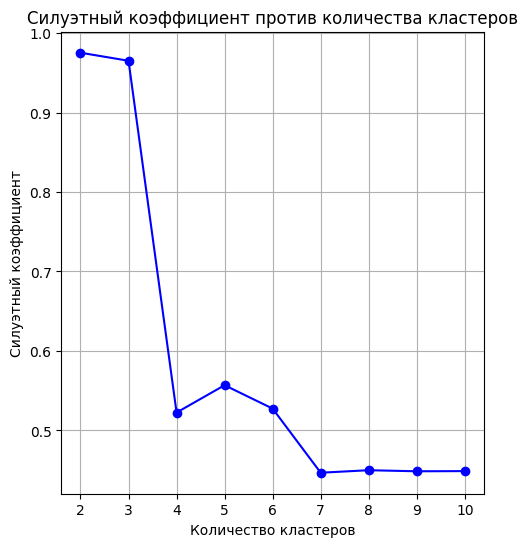

In [80]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='-', color='b')
plt.title('Силуэтный коэффициент против количества кластеров')
plt.xlabel('Количество кластеров')
plt.ylabel('Силуэтный коэффициент')
plt.grid(True)

График коэффициента Калински-Харабаша

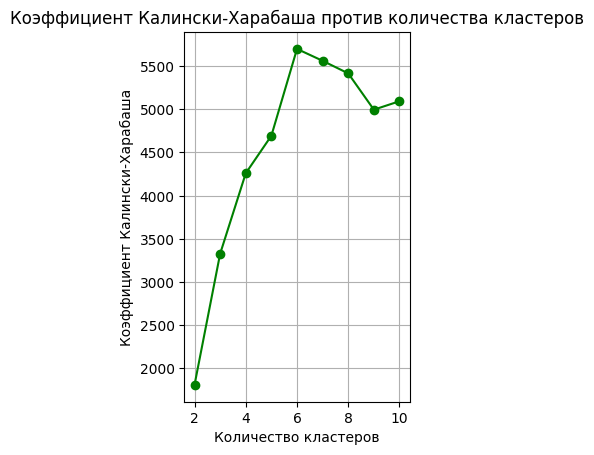

In [81]:
plt.subplot(1, 2, 2)
plt.plot(cluster_range, calinski_harabasz_scores, marker='o', linestyle='-', color='g')
plt.title('Коэффициент Калински-Харабаша против количества кластеров')
plt.xlabel('Количество кластеров')
plt.ylabel('Коэффициент Калински-Харабаша')
plt.grid(True)



Сравнение алгоритмов кластеризации

Время выполнения K-средних: 0.0066 секунд
Силуэтный коэффициент для K-средних: 0.9752


Text(0, 0.5, 'Principal Component 2')

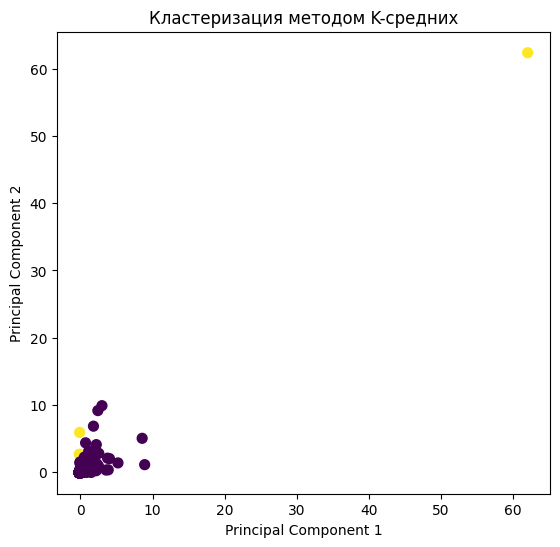

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import time


optimal_k = 2  # Замените на оптимальное значение K, найденное ранее

start_time = time.time()
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(standardized_data)
kmeans_time = time.time() - start_time


print(f"Время выполнения K-средних: {kmeans_time:.4f} секунд")


kmeans_silhouette = silhouette_score(standardized_data, kmeans_labels)
print(f"Силуэтный коэффициент для K-средних: {kmeans_silhouette:.4f}")


# Визуализация кластеров
plt.figure(figsize=(14, 6))

# K-средних
plt.subplot(1, 2, 1)
plt.scatter(standardized_data[:, 0], standardized_data[:, 1], c=kmeans_labels, cmap='viridis', marker='o', s=50)
plt.title('Кластеризация методом K-средних')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

Время выполнения DBSCAN: 0.2044 секунд
Силуэтный коэффициент для DBSCAN: 0.6230


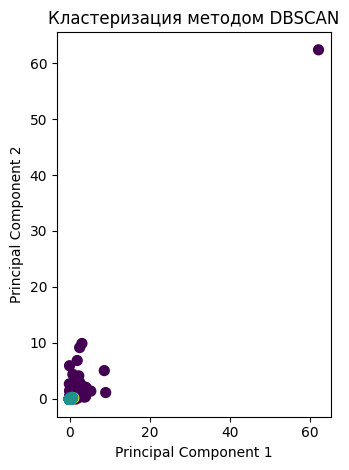

In [163]:
start_time = time.time()
dbscan = DBSCAN(eps=0.5, min_samples=9)
dbscan_labels = dbscan.fit_predict(standardized_data)
dbscan_time = time.time() - start_time


print(f"Время выполнения DBSCAN: {dbscan_time:.4f} секунд")

unique_labels = set(dbscan_labels)



dbscan_silhouette = silhouette_score(standardized_data[dbscan_labels  != -1], dbscan_labels[dbscan_labels  != -1])
print(f"Силуэтный коэффициент для DBSCAN: {dbscan_silhouette:.4f}")



# DBSCAN
plt.subplot(1, 2, 2)
plt.scatter(standardized_data[:, 0], standardized_data[:, 1], c=dbscan_labels, cmap='viridis', marker='o', s=50)
plt.title('Кластеризация методом DBSCAN')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.tight_layout()
plt.show()

In [164]:
import pandas as pd

# Преобразуем numpy массив в pandas DataFrame (если это еще не сделано)
data_df = pd.DataFrame(standardized_data, columns=[f'Feature_{i+1}' for i in range(standardized_data.shape[1])])

# Добавим метки кластеров
data_df['KMeans_Cluster'] = kmeans_labels
data_df['DBSCAN_Cluster'] = dbscan_labels


In [165]:
# Группируем данные по меткам кластеров KMeans и вычисляем средние значения по признакам
kmeans_profiles = data_df.groupby('KMeans_Cluster').mean()

# Выводим профили кластеров для KMeans
print("Кластерные профили для KMeans:")
print(kmeans_profiles)


Кластерные профили для KMeans:
                Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
KMeans_Cluster                                                          
0               -0.014247  -0.016368  -0.000116  -0.016239  -0.007489   
1               20.592077  23.657284   0.168179  23.470279  10.824164   

                Feature_6  DBSCAN_Cluster  
KMeans_Cluster                             
0               -0.020723       -0.024216  
1               29.951015       -1.000000  


In [166]:
dbscan_profiles = data_df[data_df['DBSCAN_Cluster'] != -1].groupby('DBSCAN_Cluster').mean()
print("Кластерные профили для DBSCAN:")
print(dbscan_profiles)

Кластерные профили для DBSCAN:
                Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
DBSCAN_Cluster                                                          
0               -0.042208  -0.042042   0.012967  -0.067416  -0.062771   
1                0.511454   0.088028  -0.836258   0.271968   3.650975   

                Feature_6  KMeans_Cluster  
DBSCAN_Cluster                             
0               -0.042743             0.0  
1               -0.056895             0.0  


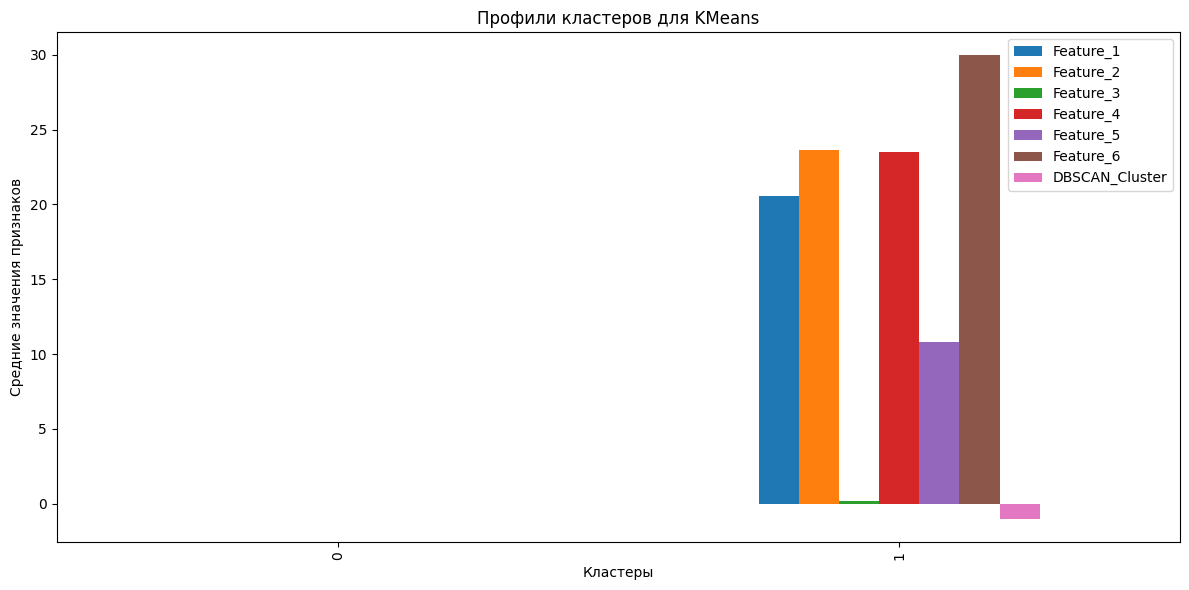

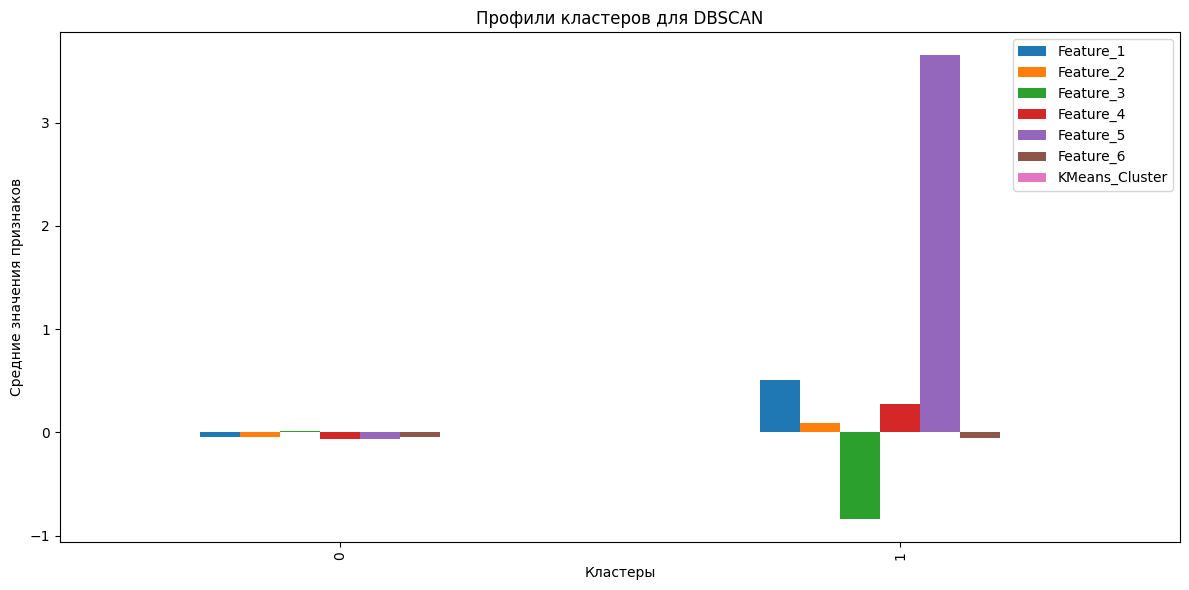

In [167]:
# Визуализируем профили кластеров для KMeans
# Визуализируем профили кластеров для KMeans
kmeans_profiles.plot(kind='bar', figsize=(12, 6))
plt.title('Профили кластеров для KMeans')
plt.xlabel('Кластеры')
plt.ylabel('Средние значения признаков')
plt.tight_layout()
plt.show()

# Визуализируем профили кластеров для DBSCAN
dbscan_profiles.plot(kind='bar', figsize=(12, 6))
plt.title('Профили кластеров для DBSCAN')
plt.xlabel('Кластеры')
plt.ylabel('Средние значения признаков')
plt.tight_layout()
plt.show()

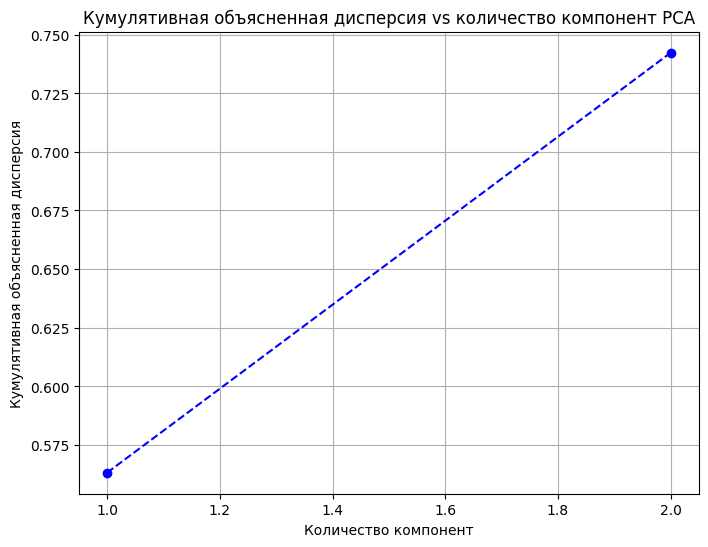

In [ ]:

pca = PCA(n_components=2)
pca_components = pca.fit_transform(standardized_data)

explained_variance = np.cumsum(pca.explained_variance_ratio_)


plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', color='b', linestyle='--')
plt.title('Кумулятивная объясненная дисперсия vs количество компонент PCA')
plt.xlabel('Количество компонент')
plt.ylabel('Кумулятивная объясненная дисперсия')
plt.grid(True)
plt.show()

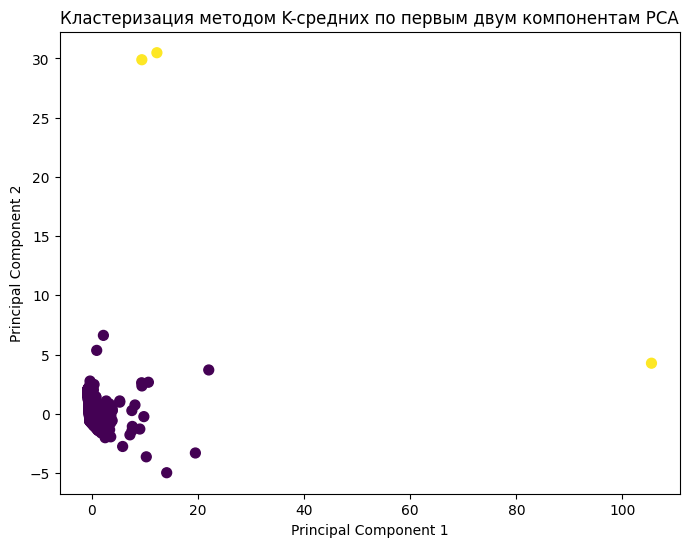

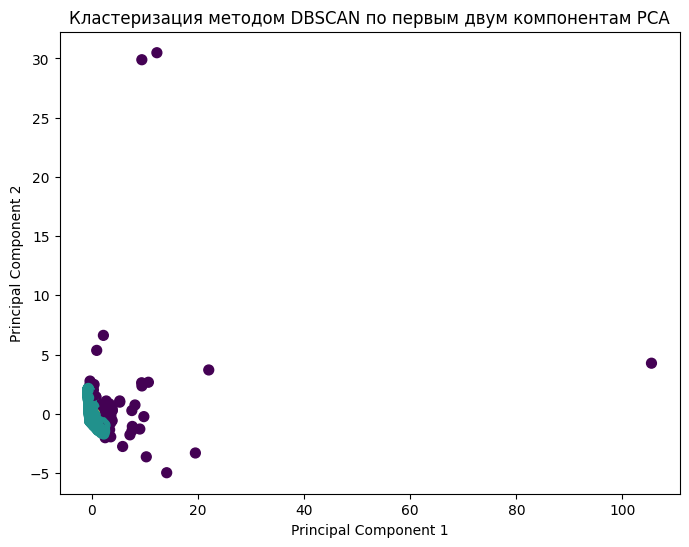

In [ ]:

optimal_k = 2  
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(standardized_data)

plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=kmeans_labels, cmap='viridis', marker='o', s=50)
plt.title('Кластеризация методом K-средних по первым двум компонентам PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


dbscan = DBSCAN(eps=0.5, min_samples=4)
dbscan_labels = dbscan.fit_predict(standardized_data)

plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=dbscan_labels, cmap='viridis', marker='o', s=50)
plt.title('Кластеризация методом DBSCAN по первым двум компонентам PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()